## Bovis strains comparative analysis with MTB complex species

In [1]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting, rdiff
import toytree, toyplot

In [4]:
meta=pd.read_csv('metadata.csv')

In [ ]:
reload(app)
args = {'threads':8,'outdir': 'results_mtb', 'labelsep':'_',
        'input':['data','/storage/btbgenie/mbovis_ireland/lab_strains/'],
         'species': 'MTB-H37Rv', 
         'overwrite':False,'unmapped':True,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [8]:
samples=pd.read_csv('results_mtb/samples.csv')
samples=samples.merge(meta,left_on='sample',right_on='name')
mapdict=dict(zip(meta.name,meta.strain))
samples['strain'] = samples['sample'].map(mapdict)

In [ ]:
treefile = 'results_mtb/tree.newick'
tre = toytree.tree(treefile)
#tre = tre.root('ref')
tre = tre.drop_tips('ref')
canvas,t,r=tre.draw(height=400,width=800)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


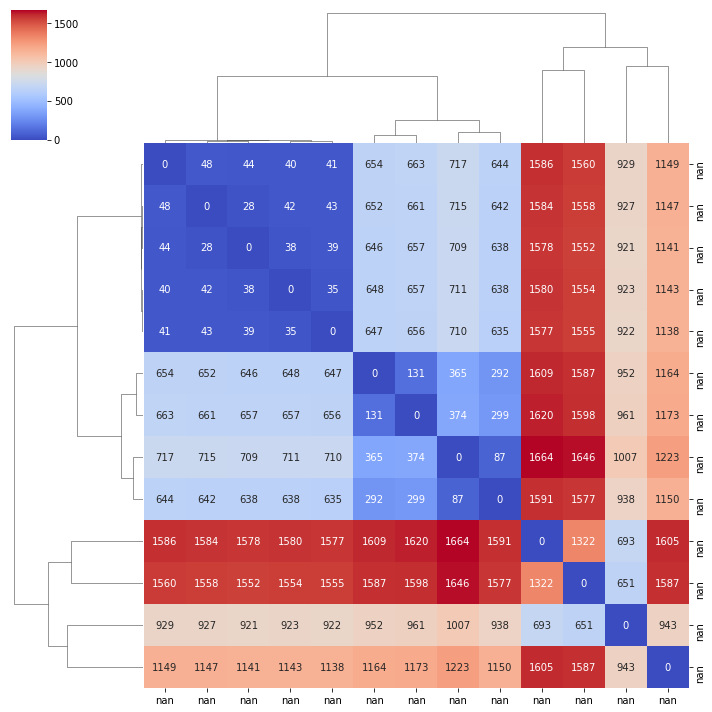

In [8]:
mat=pd.read_csv('results_mtb/snpdist.csv',index_col=0)
mat.index=mat.index.map(mapdict)
mat.columns=mat.columns.map(mapdict)
g=sns.clustermap(mat,annot=True,cmap='coolwarm',fmt='g')
#mat.style.background_gradient(cmap='coolwarm')

In [ ]:
clnames = g.data2d.index

## rd analysis

In [ ]:
from snipgenie import rdiff
rdiff.create_rd_index()
samples = pd.read_csv('results_mtb/samples.csv')
res = rdiff.run_samples(samples,'results/rd_aligned',threads=20)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
X.to_csv('rd.csv')

<AxesSubplot:ylabel='name'>

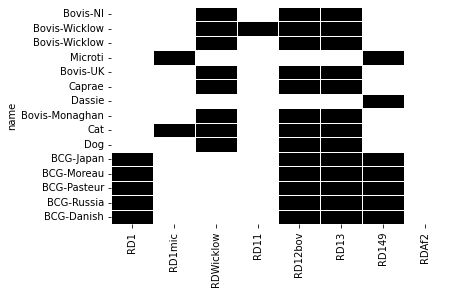

In [8]:
X=pd.read_csv('rd.csv',index_col=0)
X.index=X.index.map(mapdict)
x=X.iloc[:,:-1]
#cols=x.columns[(x.sum()<13) & (x.sum()>0)]
cols = ['RD1','RD1mic','RDWicklow','RD11','RD12bov','RD13','RD149','RDAf2']
sns.heatmap(x[cols],lw=1,ec='b',cbar=False,cmap='gray_r')

In [ ]:
X=pd.read_csv('rd.csv',index_col=0)
final=meta.merge(X[cols],left_on='name',right_index=True)
final.to_csv('final.csv',index=False)

In [7]:
#spo = tools.get_spoligotypes(samples)
#spo.to_csv('spoligotypes.csv')

In [6]:
rec = list(SeqIO.parse(app.mtb_gb,format='gb'))[0]
rec.features = [f for f in rec.features if f.type!='gene']

In [8]:
rd = pd.read_csv('/home/farrell/gitprojects/snipgenie/snipgenie/data/RD.csv')
print(rd[:10])#.sort_values('Start')

   RD_name    Start     Stop   Size            Rv
0    RD711  1501713  1503655   1943   Rv1333-1336
1    RD702   216795   218516   1722        Rv0186
2   RD1bcg  4349600  4359000   9400  Rv3871-3879c
3   RD1mic  4340400  4353500  13100   Rv3864-3871
4  RD2seal  2221000  2222900   1901  Rv1978-1979c
5   RD2bcg  2221100  2231800  10701   Rv1978-1988
6  RD12bov  3484700  3487500   2801   Rv3117-3121
7  RD12can  3479400  3491800  12401  Rv3111-3126c
8    RD105    79567    83034   3468   Rv0071-0074
9    RD239  4092077  4092919    843        Rv3651


## auto detect missing regions by binned intervals

In [14]:
a=np.zeros(1)
for i in range(3):
    x=np.random.randint(1,300,10)
    y=np.zeros(np.random.randint(10,20))
    a=np.concatenate([a,x,y])

df = pd.DataFrame({'pos': np.arange(len(a))+10,'coverage':a})
rdiff.detect_deletions(df)


,start,end,length
3,63,77,14
1,21,33,12
2,43,53,10


     start      end  length
0  2626468  2630138    3670
3  2632004  2635031    3027
4  2635577  2636930    1353
1  2630239  2631551    1312
2  2631626  2631732     106


[mpileup] 1 samples in 1 input files


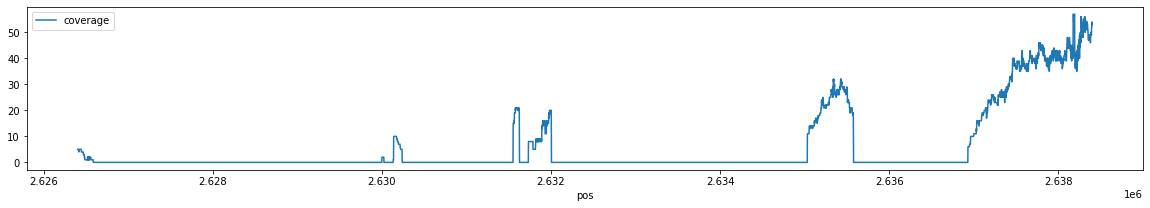

In [15]:
bam_file='results_mtb/mapped/ERR400386.bam'
bam_file='results_mtb/mapped/049-2005-NI.bam'
s=2626400;e=s+12000
reload(rdiff)
df = rdiff._get_coverage(bam_file,'NC_000962.3',s,e,app.mtb_genome)
df.plot(x='pos',y='coverage',figsize=(20,3))
ss=detect_deletions(df,thresh=3)
print (ss)


In [ ]:
for t in range(0,4):
    df = rdiff.get_coverage(bam_file,'NC_000962.3',1,2411532,app.mtb_genome,minq=10,n_cores=12)
    ss = detect_deletions(df,thresh=t)
    print (t,len(ss))

## detect deletions against MTB

In [ ]:
reload(rdiff)
s = samples[samples.strain!='Bovis-UK']
x = rdiff.get_deletions(s, app.mtb_genome, app.mtb_gb,
                              label='strain', n_cores=12)
x.to_csv('deletion_regions.csv',index=False)

In [ ]:
regions = rdiff.filter_regions(x, 'mask.bed')

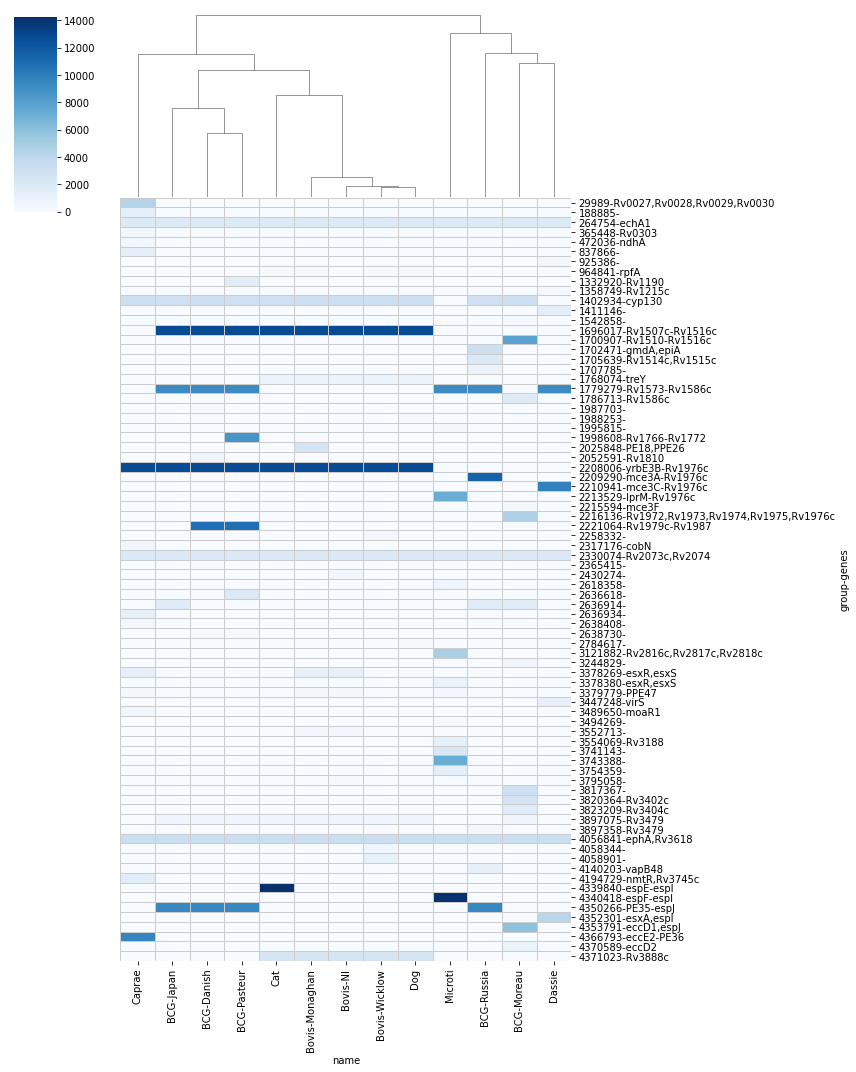

In [78]:
res=regions[regions.length>200]
X=pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
#X=X.clip(0,1)
#X=X[X.sum(1)>2]
sns.clustermap(X,cmap='Blues',row_cluster=False,yticklabels=True,lw=1,linecolor='.8',figsize=(12,15))

In [ ]:
reload(rdiff)
s=4339000;e=4390000
s=2970000;e=s+12000

rdiff.show_coverage(samples,'NC_000962.3',s,e,app.mtb_genome,app.mtb_gb, minq=0,
                      labelcol='strain',margin=100)

In [ ]:
reload(rdiff)
for i,g in list(res.groupby('group'))[20:30]:
    r=g.iloc[0]
    #print (g)
    print (r.start,r.end,r.length)
    rdiff.show_coverage(samples,'NC_000962.3',r.start,r.end,app.mtb_genome,app.mtb_gb,minq=0,
                       colors={'cat-003488':'red'},labelcol='strain',margin=200)

## M.bovis strain diffs only

In [59]:
mbsamples=pd.read_csv('results_mbovis/samples.csv')

In [10]:
treefile = 'results_mbovis/tree.newick'
tre = toytree.tree(treefile)
#tre = tre.root('ref')
tre = tre.drop_tips('ref')
canvas,t,r=tre.draw(height=400,width=800)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="400.0px" viewBox="0 0 800.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t8ac866a7bd0b46d08ce10826c384a7f1"> AF2122 T17 049-2005-NI TB19-007986 T35 dog-1034 39-MBovis TB18-003488c TB18-003488 TB18-003488b

## detect mbovis deletions

In [ ]:
s = mbsamples
x = rdiff.get_deletions(s, app.mbovis_genome, app.mbovis_gb,
                              label='sample', n_cores=12)
mbregions = rdiff.filter_regions(x, app.mbovis_mask)

res = mbregions[mbregions.length>200]

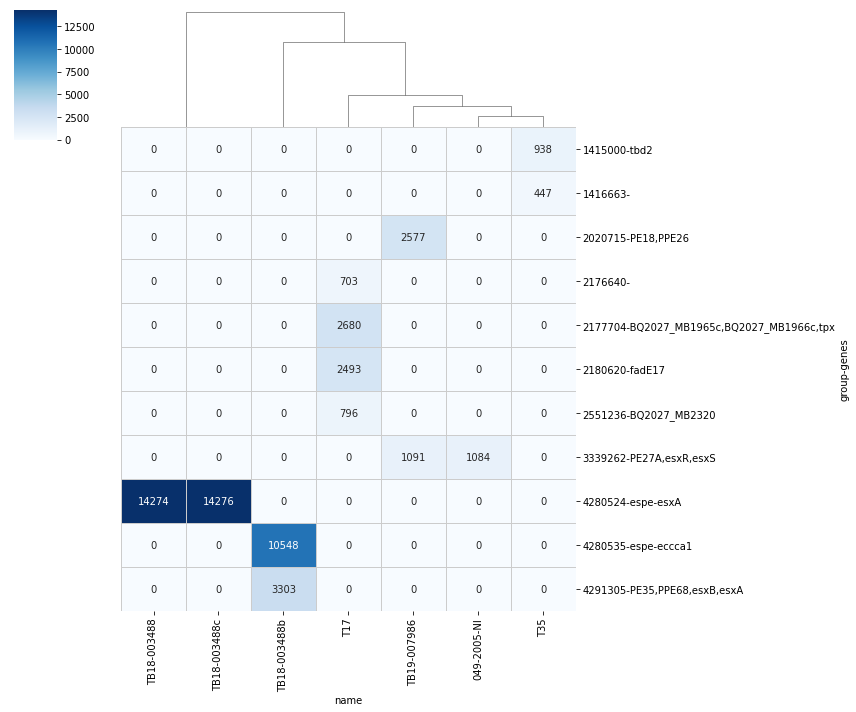

In [116]:
X = pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
#X=X.clip(0,1)
#X=X[X.sum(1)>2]
sns.clustermap(X,cmap='Blues',row_cluster=False,yticklabels=True,lw=1,linecolor='.8',annot=True,fmt='.0f',figsize=(12,10))

## detect insertions using unmapped reads method

In [141]:
#assemble unmapped reads
unbams=app.get_samples_from_bams(glob.glob('results_mbovis/unmapped/*.fastq.gz'))
path='unmapped_assembly'
for name,df in unbams.groupby('sample'):    
    print (name)  
    print (df.sort_values('bam_file'))
    f1 = df.iloc[0]['bam_file']
    f2 = df.iloc[1]['bam_file']
    tools.spades(f1,f2,os.path.join(path,name),os.path.join(path,name+'.fa'))

TB18-003488
                                     name       sample                                           bam_file
3  TB18-003488_S32_L001-4_R1_001.fastq.gz  TB18-003488  /storage/bcg_cat/results_mbovis/unmapped/TB18-...
4  TB18-003488_S32_L001-4_R2_001.fastq.gz  TB18-003488  /storage/bcg_cat/results_mbovis/unmapped/TB18-...
spades -t 4 --pe1-1 /storage/bcg_cat/results_mbovis/unmapped/TB18-003488_S32_L001-4_R1_001.fastq.gz --pe1-2 /storage/bcg_cat/results_mbovis/unmapped/TB18-003488_S32_L001-4_R2_001.fastq.gz --careful -o unmapped_assembly/TB18-003488
unmapped_assembly/TB18-003488.fa
TB18-003488b
                                      name        sample                                           bam_file
1  TB18-003488b_S69_L001-4_R1_001.fastq.gz  TB18-003488b  /storage/bcg_cat/results_mbovis/unmapped/TB18-...
5  TB18-003488b_S69_L001-4_R2_001.fastq.gz  TB18-003488b  /storage/bcg_cat/results_mbovis/unmapped/TB18-...
spades -t 4 --pe1-1 /storage/bcg_cat/results_mbovis/unmapped/TB18-003

## assembly

In [ ]:
reload(tools)
path = 'assembly'
for i,r in mbsamples.iterrows():
    name=r['sample']
    print (name)
    if name in ['AF2122']: continue
    #tools.spades(r.filename1,r.filename2,os.path.join(path,name),os.path.join(path,name+'.fa'))


In [ ]:
#indels
v=tools.vcf_to_dataframe('results_mbovis/indels.vcf.gz')
v['length']=v.end-v.start
#v.sort_values('length')
mat=pd.pivot_table(v,index='sample',columns='start',values='length').T
mat

## Use mtbdiff to detect large indels for M.bovis samples

Uses Mummer/nucdiff to align contigs to a reference genome. This method returns a lot of noisy results that need to be filtered. Probably artifacts of the assembly.

In [ ]:
import mtbdiff
path = 'bovis_assembly'
names = mtbdiff.run_genomes(path, outpath='mtb_diff')#, ref=app.mbovis_genome)

In [49]:
struct, snp =  mtbdiff.get_nucdiff_results('bovis_diff', names, 'Mbovis_AF212297')
struct['RD'] = struct.apply(mtbdiff.get_region,1)
struct=struct[struct.length>10]
struct=struct.merge(meta,left_on='label',right_on='name')

In [83]:
struct.Name.value_counts()

deletion                   127
substitution               124
collapsed_tandem_repeat    103
collapsed_repeat            88
gap                         48
inversion                   12
Name: Name, dtype: int64

In [120]:
sel=['T17']
found=struct[(struct.Name=='gap') & (struct.label.isin(sel))]
found

,ID,Name,color,descr,end,label,length,query_coord,query_sequence,source,start,insertion_length,RD,name,strain,species
404,SV_211,gap,#42C042,gap_578384:578481,578481,T17,97,46515-46611,NODE_18_length_75798_cov_28.840744,NucDiff_v2.0,578384,96,-,T17,T17,Bovis
406,SV_214,gap,#42C042,gap_581751:581849,581849,T17,98,49866-49963,NODE_18_length_75798_cov_28.840744,NucDiff_v2.0,581751,97,-,T17,T17,Bovis
441,SV_92,gap,#42C042,gap_1972998:1973074,1973074,T17,76,14215-14290,NODE_6_length_117949_cov_24.654931,NucDiff_v2.0,1972998,75,-,T17,T17,Bovis
452,SV_104,gap,#42C042,gap_2386769:2386827,2386827,T17,58,22631-22688,NODE_7_length_114884_cov_24.173204,NucDiff_v2.0,2386769,57,-,T17,T17,Bovis
464,SV_225,gap,#42C042,gap_2957080:2957179,2957179,T17,99,58846-58944,NODE_20_length_71299_cov_26.283438,NucDiff_v2.0,2957080,98,-,T17,T17,Bovis
474,SV_268,gap,#42C042,gap_3193658:3193714,3193714,T17,56,43947-44002,NODE_26_length_59244_cov_27.249125,NucDiff_v2.0,3193658,55,-,T17,T17,Bovis
497,SV_280,gap,#42C042,gap_4000803:4000902,4000902,T17,99,35445-35543,NODE_28_length_58346_cov_28.726287,NucDiff_v2.0,4000803,98,-,T17,T17,Bovis


In [ ]:
for i,r in found.iterrows():
    print (r.start,r.end)
    rdiff.show_coverage(mbsamples,'LT708304.1',r.start,r.end,app.mbovis_genome,app.mbovis_gb,minq=0,
                      labelcol='sample',margin=200) # colors={'cat-003488':'red'}
    plt.show()

In [ ]:
filt = struct#[struct.region!='PE/PPE']
rdmat = mtbdiff.RD_matrix(filt, columns=['label'])
#print (rdmat)
smat = mtbdiff.sites_matrix(filt, columns=['label'], freq=1)
print (smat)
#smat.to_csv('sites_matrix.csv',index=False)
#species = smat.T.index.get_level_values(0)
#lut = dict(zip(species.unique(), "rbg"))
#row_colors = species.map(lut)

In [ ]:
X=smat.T
#cm = mtbdiff.plot_RD(X, width=20,col_cluster=False)
f,ax=plt.subplots(1,1,figsize=(24,6))
sns.heatmap(X,ax=ax)

## IGV viewer

https://github.com/igvteam/igv.js/wiki/Tracks-2.0


In [75]:
from igv_jupyterlab import IGV

url = 'http://localhost:8890/files/'

bams={'cat':'results_mtb/mapped/cat-003488.bam',
      'microti':'results_mtb/mapped/ERR027294.bam',
      'mbovis-dog':'results_mtb/mapped/dog-1034.bam'}

track_list = [{"name": "MTB-H37Rv",
                "url": url+"results_mtb/MTB-H37Rv.gb.gff",
                "format": "gff",
                "type": "annotation",
                "height":120,
                "indexed": False }              
             ]

colors=['orange','green','gray']
i=0
for b in bams:
    d = {"name": b,
        "url":url+bams[b],
        "type": "alignment",
         "displayMode":"SQUISHED",
         "height":130,
         "removable":True,
         "color":colors[i],
        "indexed": True }
    track_list.append(d)
    i+=1

genome = IGV.create_genome(
    name="MTB-H37Rv",   
    fasta_url=url+'MTB-H37Rv.fa',
    index_url=url+'MTB-H37Rv.fa.fai',
    tracks=track_list
)

igv = IGV(genome=genome)
igv.locus="NC_000962.3:4338155-4343654"
display(igv)


IGV(id='igv_3876011', initialConfig={'id': 'igv_3876011', 'locus': '', 'reference': {'name': 'MTB-H37Rv', 'fas…